In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from cleaning_pipeline import goods, full_prod_orders

# Use to reimport module if you make change to the .py
# importlib.reload(cleaning_pipeline)

In [9]:
from __future__ import print_function
from sklearn.cluster import KMeans
from PlottingFunctions import plot_inertia, plot_silhouette

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

import seaborn as sns

In [180]:
def plot_PCA(df, scale=True, plot_x='PC1', plot_y='PC2', return_df=False):
    '''Scale a dataframe and calculate its principal components
    
    Args: 
        takes a dataframe 
        
    Returns:
        the explained variance ratio for all components
        the plot of the first two components

    '''
    pc_list = range(1, len(df.columns.tolist())+1)
    pc_number = ['PC'+str(i) for i in pc_list]
    
    # Scale data 
    if scale:
        scaler = StandardScaler()
        scaler.fit(df)
        df = scaler.transform(df)


    # build PCA
    pca = PCA()
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = pc_number)

    # Plot PCA
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    ax.scatter(principalDf[[plot_x]],
               principalDf[[plot_y]],
                s = 50)
    
    
    if return_df:
        return pd.DataFrame(principalComponents)
#         df_return = pd.DataFrame(principalComponents)
#         var_ratio = pca.explained_variance_ratio_.tolist()
#         return (df_return, var_ratio)

    return pca.explained_variance_ratio_

## Cluster based on aggregate stats from Jordan
- K-Means with k = 3 based on elbow plot
- PCA of full and reduced datasets

In [28]:
user_summary = pd.read_csv('../data/user_summary.csv')
user_summary = user_summary.drop(['mode_day_of_week', 'mode_hour_of_day'],axis=1)

In [25]:
kmeans = KMeans()
kmeans.set_params(n_clusters=3)
kmeans.fit(user_summary)

# plot_inertia(kmeans, user_summary.iloc[:,0:2].values, range(1, 10))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

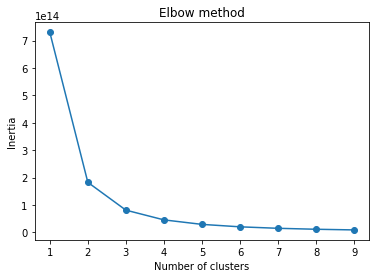

In [23]:
# Use K = 3
plot_inertia(kmeans, user_summary, range(1, 10))

In [28]:
# K-means evenly split the groups. Seems suspicious
pd.Series(kmeans.labels_)

1    68857
2    68737
0    68615
dtype: int64

[3.35896650e-01 2.38474891e-01 1.20463163e-01 9.62285285e-02
 7.81324471e-02 5.09846463e-02 2.76148521e-02 2.00146404e-02
 9.95736706e-03 7.47169529e-03 5.59076239e-03 4.01561586e-03
 1.85522603e-03 1.71216164e-03 1.20478234e-03 3.66078414e-04
 1.64917395e-05]


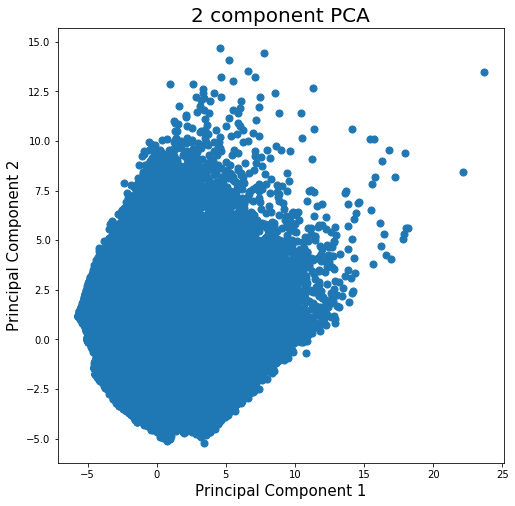

In [29]:
pca_users = user_summary.drop('user_id', axis=1)
plot_PCA(pca_users)

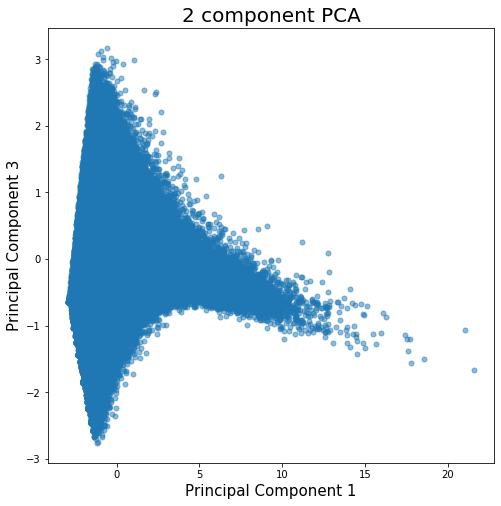

In [101]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf[['PC1']],
           principalDf[['PC3']],
            s = 25, alpha=0.5)

[5.99229480e-01 1.94823481e-01 9.95653124e-02 8.65114432e-02
 1.98231776e-02 4.71063083e-05]


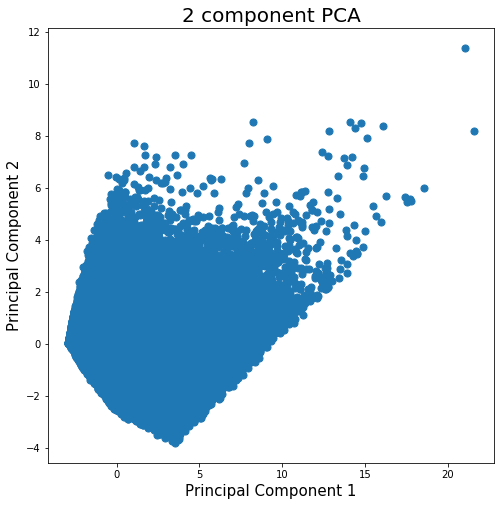

In [30]:
# Make reduced PCA using fewer stats
new_list = user_summary.columns.tolist()[:-1]
indices = [1,2,6,10,12,-1]
subset_list = [new_list[i] for i in indices]
reduced_users = user_summary[subset_list]

plot_PCA(reduced_users)

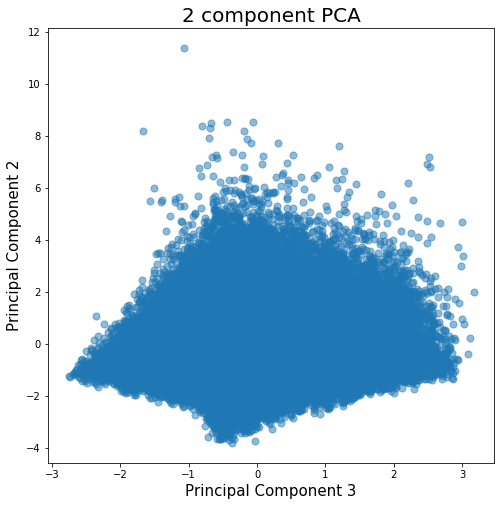

In [100]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf[['PC3']],
           principalDf[['PC2']],
            s = 50, alpha=0.5)

## Clustering based on Department


1. Make a table with number items bought in each dept  by customer
2. Make a table with items bought per aisle by each customer
2. create a purchase summary matrix:
    - columns representing each product available for purchase
    - rows representing each customer
    - then use sparse matrix?
    
    

In [3]:
dept_user_df = full_prod_orders.groupby(['user_id','department'], as_index=False).product_id.agg('count')
dept_user_df = dept_user_df.pivot(index='user_id', columns='department', values = 'product_id')
dept_user_df = dept_user_df.fillna(0)

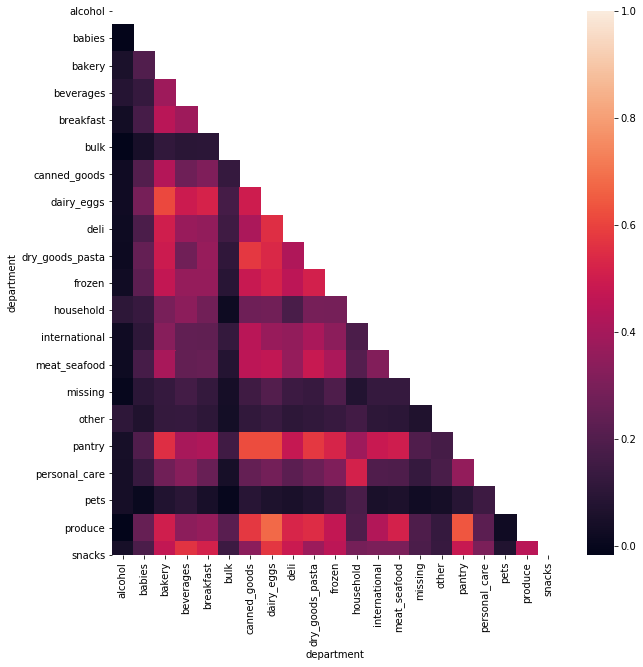

In [5]:
# Which departments are correlated with each other?
plt.figure(figsize=(10,10))
matrix_ = np.triu(dept_user_df.corr())
sns.heatmap(dept_user_df.corr(), mask=matrix_)

In [57]:
corr_ = dept_user_df.corr()
corr_.produce.sort_values(ascending=False)

department
produce            1.000000
dairy_eggs         0.681753
pantry             0.641524
canned_goods       0.575268
dry_goods_pasta    0.549380
deli               0.529558
meat_seafood       0.519165
bakery             0.503731
frozen             0.470107
snacks             0.446274
international      0.431822
breakfast          0.363398
beverages          0.344518
babies             0.252905
personal_care      0.221652
bulk               0.218941
missing            0.191358
household          0.190607
other              0.126151
pets               0.026537
alcohol           -0.016976
Name: produce, dtype: float64

In [67]:
corr_.other.sort_values(ascending=False)

department
other              1.000000
personal_care      0.178739
pantry             0.166465
household          0.161164
dairy_eggs         0.134856
frozen             0.130909
snacks             0.130750
beverages          0.126744
produce            0.126151
bakery             0.124787
canned_goods       0.116117
dry_goods_pasta    0.114326
alcohol            0.109088
deli               0.104364
international      0.104023
breakfast          0.102228
meat_seafood       0.100583
missing            0.067892
babies             0.067667
pets               0.042348
bulk               0.036791
Name: other, dtype: float64

#### Create Percentage Dept_user-df

In [4]:
dept_user_df['total_items'] = dept_user_df.sum(axis=1)
cols = dept_user_df.columns[:-1]
dept_percent_df = dept_user_df[cols].div(dept_user_df.total_items, axis=0)

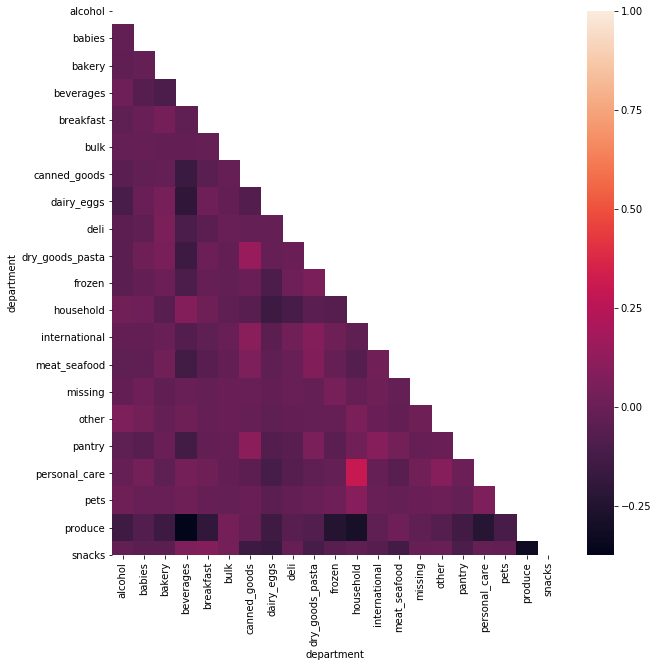

In [12]:
# Same data but each user is normalized to percent to account for total items bought
plt.figure(figsize=(10,10))
matrix_ = np.triu(dept_percent_df.corr())
sns.heatmap(dept_percent_df.corr(), mask=matrix_)

### Conclusions from Correlation
- High correlation of produce, dairy/eggs, and pantry items
- Babies does not have any strong correlation
    - highest corr is 0.289, dairy/eggs
- Dairy/Eggs correlates with many other categories
- Alcohol, pets, missing and other don't have any strong correlations
    - all less than 0.25



### Clustering on Users based on items bought per department

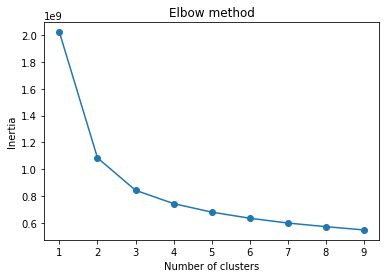

In [18]:
kmeans = KMeans()
plot_inertia(kmeans, dept_user_df, range(1, 10))

In [24]:
# K-means for using 9 clusters
pd.Series(kmeans.labels_).value_counts()

2    112472
6     46534
0     18797
4     10379
3      7321
7      5130
1      3870
5      1052
8       654
dtype: int64

In [28]:
# Labelling for clustering (n=4) based on departments
kmeans.set_params(n_clusters=4)
kmeans.fit(dept_user_df)
pd.Series(kmeans.labels_).value_counts()

1    144304
3     43066
0     14826
2      4013
dtype: int64

#### Only cluster 2 seems to be good. The other are split and the average silhouette is fairly low (~0.43)

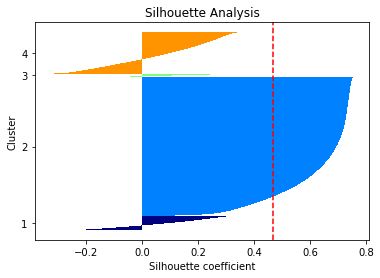

In [27]:
plot_silhouette(kmeans, dept_user_df)

## PCA followed by K-Means

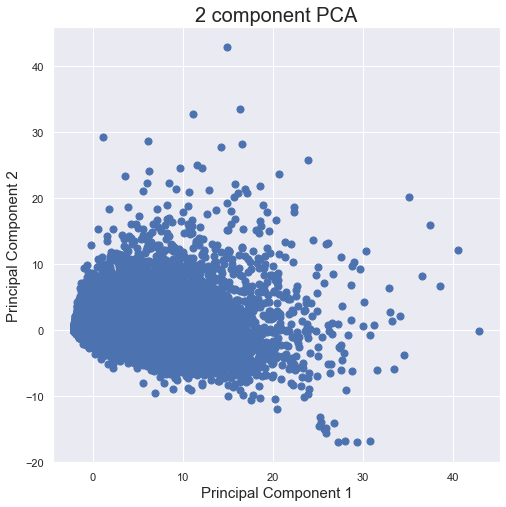

In [148]:
# Run PCA on raw items bought per department per user. User_id not included in PCA bc it's the index
dept_user_df_raw = dept_user_df.drop(labels='total_items', axis=1)
pca_raw_explained_variance_ratio = plot_PCA(dept_user_df_raw)

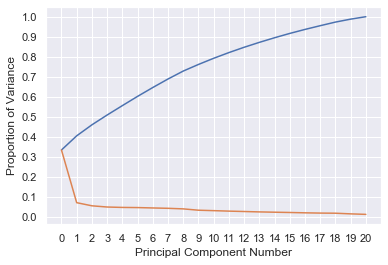

In [170]:
# Scree Plot of Principal Components to decide how many to include in KMeans
cum_sum_pca_var = np.cumsum(pca_raw_explained_variance_ratio)
x = np.arange(0,21)

plt.plot(x, cum_sum_pca_var, label='Cumulative Variance')
plt.plot(x, pca_raw_explained_variance_ratio, label= 'Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Variance')
plt.xticks(np.arange(0,21))
plt.yticks(np.arange(0,1.1,0.1))
plt.show()

In [187]:
dept_user_pca_df = plot_PCA(dept_user_df, return_df=True)
plt.clf()

<Figure size 576x576 with 0 Axes>

In [191]:
# Dataframe with 80% of variance from first 10 components
pca_df_10_components = dept_user_pca_df[np.arange(11)]

# Dataframe with 90% of variance from first 14 components
pca_df_14_components = dept_user_pca_df[np.arange(15)]


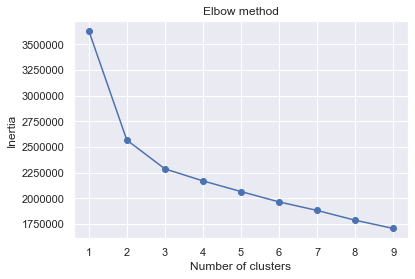

In [192]:
kmeans_pca = KMeans()
plot_inertia(kmeans_pca, pca_df_10_components, range(1, 10))

In [194]:
kmeans_pca.set_params(n_clusters=4)
kmeans_pca.fit(pca_df_10_components)
pd.Series(kmeans_pca.labels_).value_counts()

1    140634
0     45898
2     15836
3      3841
dtype: int64

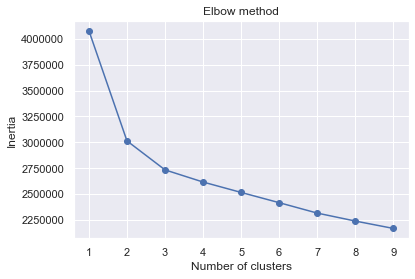

In [195]:
kmeans_pca_14 = KMeans()
plot_inertia(kmeans_pca_14, pca_df_14_components, range(1, 10))

In [197]:
kmeans_pca_14.set_params(n_clusters=4)
kmeans_pca_14.fit(pca_df_14_components)
pd.Series(kmeans_pca_14.labels_).value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         2
2         0
3         0
4         0
         ..
206204    0
206205    2
206206    2
206207    3
206208    0
Length: 206209, dtype: int32>

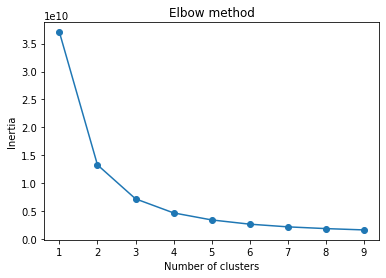

In [49]:
# Inertia plot of all components
plot_inertia(kmeans, dept_user_pca_df, range(1, 10))

In [50]:
kmeans.set_params(n_clusters=4)
kmeans.fit(dept_user_pca_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [54]:
# K-Means results using all components
pd.Series(kmeans.labels_).value_counts()

1    141711
3     44727
0     15717
2      4054
dtype: int64

# Part 2. Identify Sub-populations of customers based on items bought
1. Parents: ~35,000 shoppers who buy baby items
2. Pet owners: ~15,500 shoppers who buy pet items
3. Drinkers: ~16,000 shoppers who buy alcohol

#### Groups are fairly distinct
1. 90% of parents dont have pets
2. 94% of parents don't buy alcohol
3. 86% of drinkers don't buy pet items

In [7]:
# 34782 shoppers bought baby items
# Max = 821, Mean = 12.6, Median = 4 
parents = dept_user_df[dept_user_df.babies >0]
parents.to_csv('../data/parents.csv')
# 15484 shoppers who bought pet items
# Max = 522
# Median = 3, Mean = 6.6
pet_owners = dept_user_df[dept_user_df.pets >0]
pet_owners.to_csv('../data/pet_owners.csv')
# 16104 shoppers bought alcohol
# One shopper bought 685 alcohol items
# median = 4, avg = 9.9
drinkers = dept_user_df[dept_user_df.alcohol >0]
drinkers.to_csv('../data/drinkers.csv')

In [14]:
# Calculate percent of users that overlap in other groups
# Example: Number of drinkers who do not buy pet items
drinkers.pets.value_counts()[0]/drinkers.shape[0]

0.8569920516641828

In [16]:
# Concatenate parents, pet_owners and drinkers, Expected shape = 66370 (34782+15484+16104)
df_list = [parents, pet_owners, drinkers]
subgroups_df = pd.concat(df_list)
subgroups_df.shape

(66370, 21)

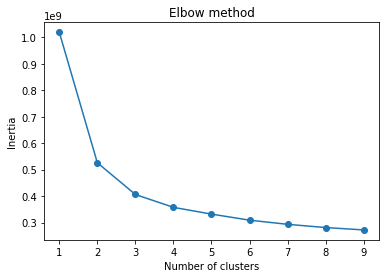

In [20]:
kmeans = KMeans()
plot_inertia(kmeans, subgroups_df, range(1, 10))

In [21]:
kmeans.set_params(n_clusters=3)
kmeans.fit(subgroups_df)

pd.Series(kmeans.labels_).value_counts()

0    49049
2    13630
1     3691
dtype: int64

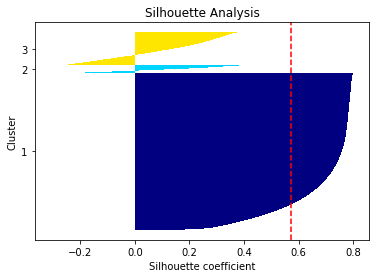

In [22]:
plot_silhouette(kmeans, dept_user_df)

### K-means does not pick out the same clusters that I did (parents, pet owners, drinkers)
1. Distribution of labels is not the same as the ground truth
2. 2 Clusters do not seem appropriate based on silhouette
3. But getting less inertia than clustering on the full department data


[0.35544616 0.07681879 0.05004922 0.04871851 0.04639032 0.04429849
 0.04218555 0.04010953 0.03667281 0.03282921 0.03003704 0.02642
 0.02560031 0.02374207 0.02154841 0.02078799 0.01892591 0.01846154
 0.01664407 0.01421688 0.01009719]


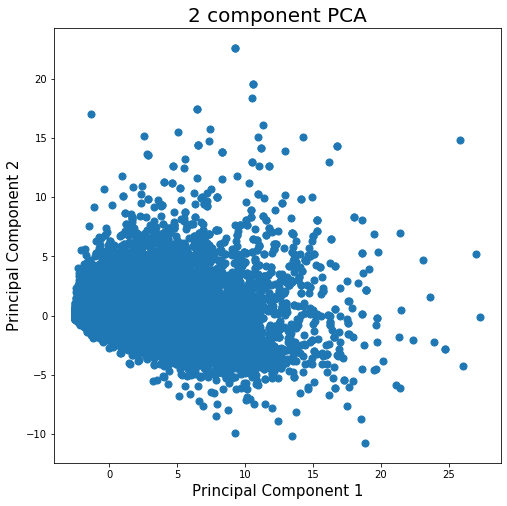

In [24]:
plot_PCA(subgroups_df)

# Part 3. Hierarchical Clustering of Users by Department

#### Randomly Sampling Dataset to reduce to 20,000 observations

1. Most departments do not add much information to clustering
2. Can see some clusters but they are fairly diffuse.
3. Concern with this method that clustering will change based on down-sampling

#### K-means clustering to reduce datapoints

1. Hierarchical clustering on 200k datapoints will require too much memory so use K-means to reduce the resolution
2. Also use MiniBatchKmeans to increase speed
    - Requirement: batch_size > n_clusters     
2. Determining number of clusters to use:
    - Start with Minibatch with k = sqrt(n) aka 450, batch = 1000, observe reasonable clusters
    - Large n_clusters (20,000 and 2,000) led to several clusters with only 1 or 2 observations and didn't cluster well
    - Decreasing n_clusters improves dendrogram interpretability
    - 250 K-means clusters and 500 samples per batch gives best balance of interpretability and clustering success
3. Clustering only on 8 columns that contain majority of information improves performance
4. Data is scaled by row, (percentage items bought per department)
    - scaling 800,1000 by columns did not improve clustering



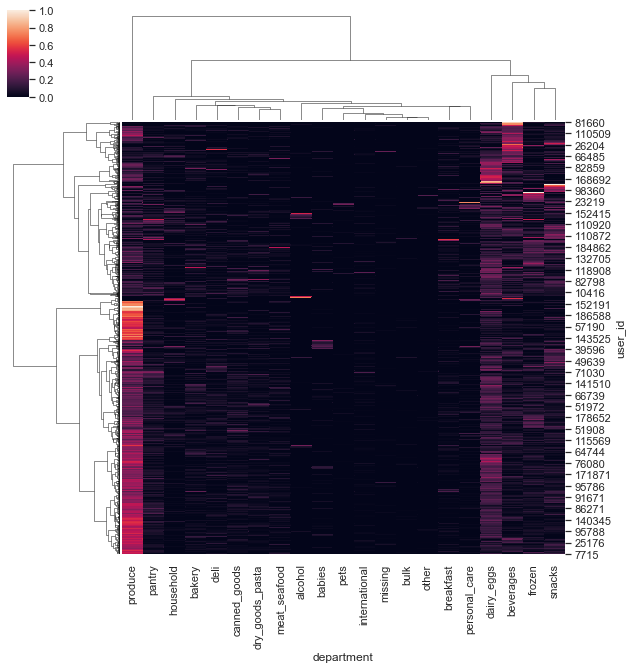

In [5]:
# Take 20,000 random user_ids and perform Hierarchical clustering
import seaborn as sns; sns.set(color_codes=True)

users_random_sample = dept_percent_df.sample(20000, random_state=42)
g = sns.clustermap(users_random_sample, method='ward')

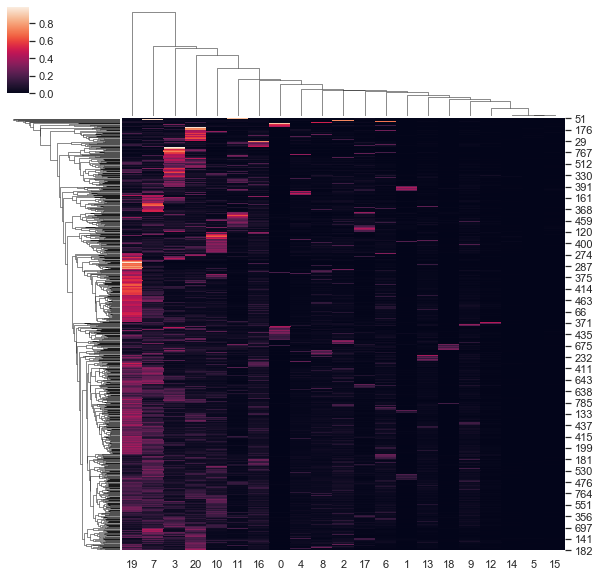

In [126]:
# Clustering on full dataset grouped by K-means
from sklearn.cluster import MiniBatchKMeans
kmeans =  MiniBatchKMeans(n_clusters=800, random_state=42,batch_size=1000)
kmeans.fit(dept_percent_df)

sns.clustermap(kmeans.cluster_centers_)

Text(0, 0.5, 'Number of Observations')

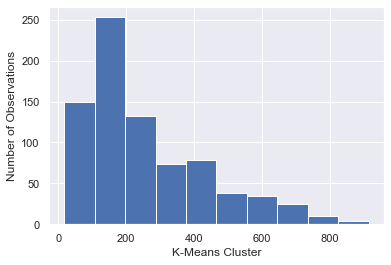

In [125]:
plt.hist(pd.Series(kmeans.labels_).value_counts())
plt.xlabel('K-Means Cluster')
plt.ylabel('Number of Observations')

In [344]:
# Get subsets of columns with most information to narrow clustering
col_list = [19,7,3,20,10,16,11,0]
name_list = dept_percent_df.columns.tolist()
sub_cols = [name_list[i] for i in col_list]

In [345]:
# Get subsets of columns with most information to narrow clustering
col_list = [19,7,3,20,10,16,11,0,1]
name_list = dept_percent_df.columns.tolist()

sub_cols_babies = [name_list[i] for i in col_list]


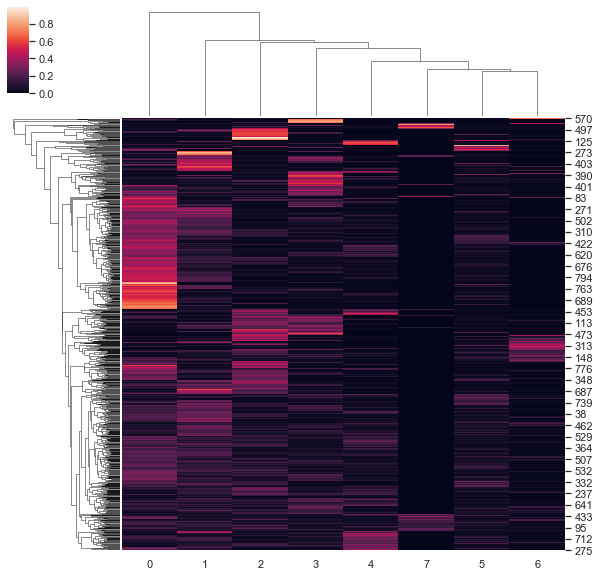

In [108]:
# Cluster on 8 departments only
kmeans_8 =  MiniBatchKMeans(n_clusters=800, random_state=42,batch_size=1000)
kmeans_8.fit(dept_percent_df[sub_cols])

g = sns.clustermap(kmeans_8.cluster_centers_,)

(array([150., 253., 132.,  74.,  79.,  38.,  35.,  25.,  10.,   4.]),
 array([ 18. , 107.6, 197.2, 286.8, 376.4, 466. , 555.6, 645.2, 734.8,
        824.4, 914. ]),
 <a list of 10 Patch objects>)

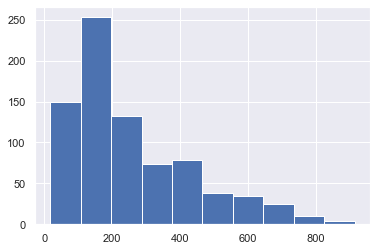

In [109]:
plt.hist(pd.Series(kmeans_8.labels_).value_counts())

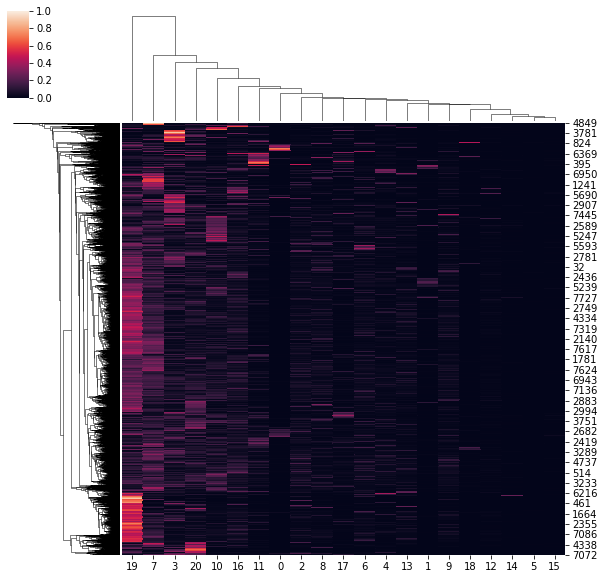

In [6]:
kmeans =  MiniBatchKMeans(n_clusters=8000, random_state=42,batch_size=10000)
kmeans.fit(dept_percent_df)

g = sns.clustermap(kmeans.cluster_centers_)

2310    381
1015    261
98      136
19      125
4288    111
       ... 
3868      3
5242      3
5308      3
4605      2
5480      2
Length: 8000, dtype: int64

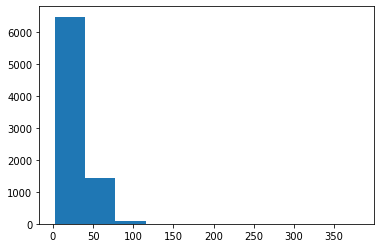

In [8]:
plt.hist(pd.Series(kmeans.labels_).value_counts())
pd.Series(kmeans.labels_).value_counts()

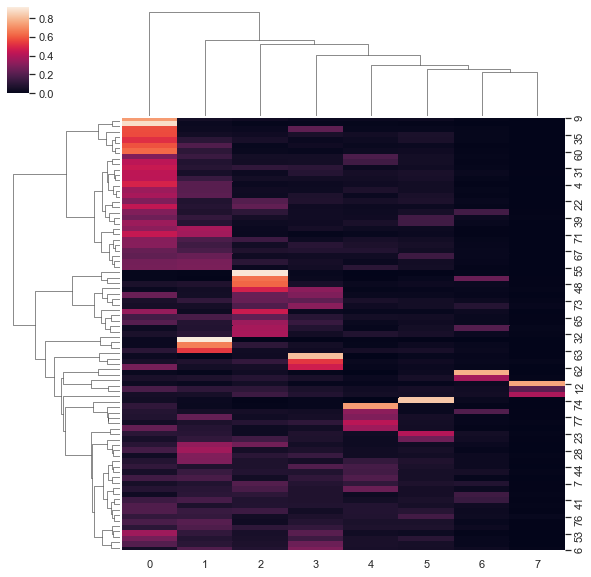

In [13]:
kmeans_80 =  MiniBatchKMeans(n_clusters=80, random_state=42,batch_size=2000)
kmeans_80.fit(dept_percent_df[sub_cols])

g_80 = sns.clustermap(kmeans_80.cluster_centers_, method='ward')

In [94]:
kmeans_250 =  MiniBatchKMeans(n_clusters=250, random_state=42,batch_size=500)
kmeans_250.fit(dept_percent_df[sub_cols])

MiniBatchKMeans(batch_size=500, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=250, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

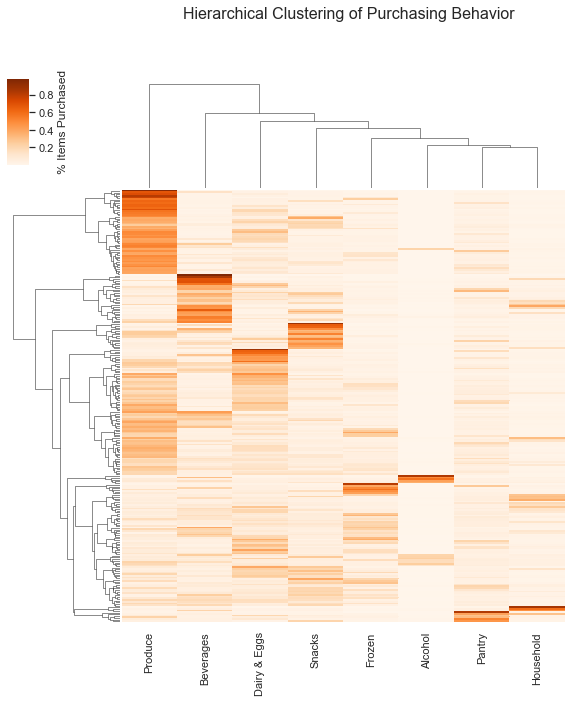

In [343]:
# 250, 500 KEEP
xlabels_sns = ['Produce', 'Dairy & Eggs', 'Beverages', 'Snacks', 'Frozen', 'Pantry','Household', 'Alcohol']

g_250_500 = sns.clustermap(kmeans_250.cluster_centers_, method='ward', cmap='Oranges',
                           cbar_kws={'label': '% Items Purchased'}, 
                          xticklabels=xlabels_sns,
                          yticklabels=False
                          )

plt.suptitle("Hierarchical Clustering of Purchasing Behavior", x = 0.6, fontsize=16)

plt.savefig('7cluster_Oranges.pdf', format='pdf')
# plt.colorbar()
# 1.7 -> 5 groups: Produce, Beverages, Snacks, medium prod/ dairy, grab-bag
# 1.6 -> 7 groups: Produce, Beverages, Snacks, Dairy, Medium Produce, Alcohol, Grab-bag

36     2586
107    2540
56     2272
204    2261
152    2252
       ... 
130     117
22      116
12      115
196      94
78       62
Length: 250, dtype: int64

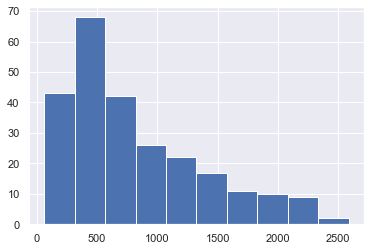

In [93]:
plt.hist(pd.Series(kmeans_250.labels_).value_counts())
pd.Series(kmeans_250.labels_).value_counts()

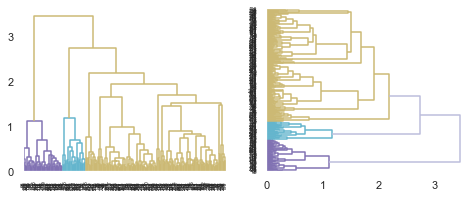

In [100]:
dgram = g_250_500.dendrogram_row.dendrogram

row_linkage = g_250_500.dendrogram_row.linkage

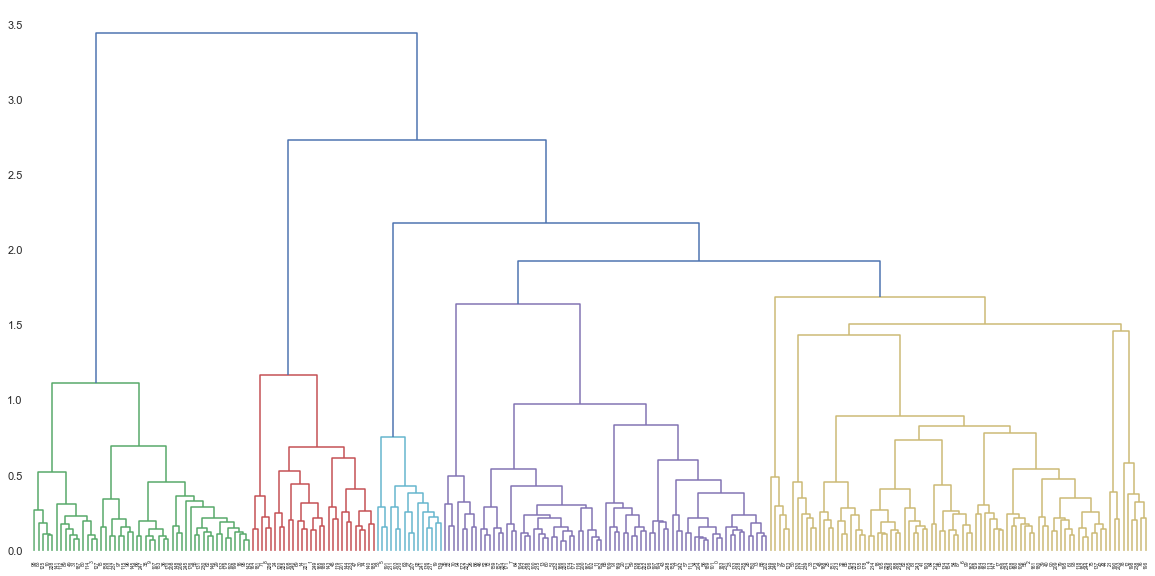

In [350]:
# Threshold = 1.7, yields 5 clusters

hierarchy.set_link_color_palette(None) 
fig = plt.figure(figsize=(20,10))
plt.rcParams['axes.facecolor']='white'
dn5 = hierarchy.dendrogram(row_linkage, color_threshold=1.7)
plt.savefig('dgram_5clusters.pdf', format='pdf')


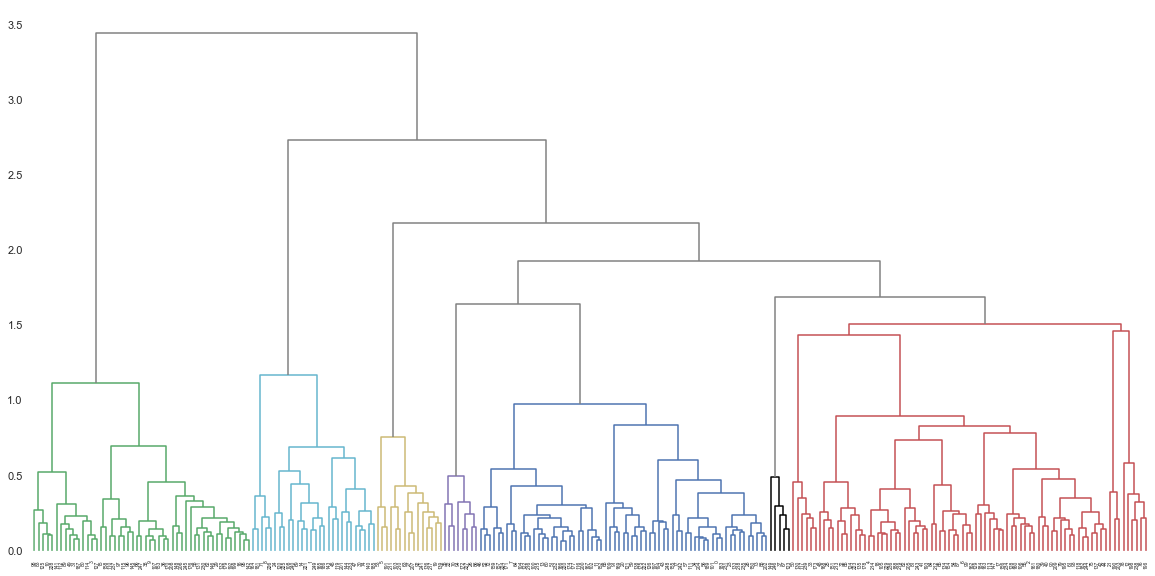

In [351]:
# Threshold = 1.6, yields 7 clusters
plt.figure(figsize=(20, 10))
hierarchy.set_link_color_palette(['g','c','y','m','b','black', 'r']) 

plt.rcParams['axes.facecolor']='white'
hierarchy.dendrogram(row_linkage, color_threshold=1.6, 
                          above_threshold_color='grey')

plt.savefig('dgram_7clusters.pdf', format='pdf')

In [216]:
# 250 Kmeans Ids in order of dendrogram 
kmeans_id_ordered = g_250_500.dendrogram_row.reordered_ind

# 206209 users to 250 Kmeans labels
user_id_to_kmeans_id = pd.DataFrame(kmeans_250.labels_, index=np.arange(1,206210), columns=['kmeans_id'])


,kmeans_id
1,136
2,202
3,66
4,81
5,107


In [265]:
#  fcluster() to define threshold and assign kmeans ids to a cluster
# Change t=1.6 to get 7 clusters instead of 5 
kmeans_id_to_5cluster = pd.DataFrame(fcluster(row_linkage,  t=1.7, criterion='distance'), index=np.arange(250), 
                                   columns=['cluster_id'])

,cluster_id
0,4
1,2
2,5
3,1
4,5


In [223]:
# Merge dataframes to map hierarchical clusters to individual user_ids
user_id_to_cluster_df = pd.merge(user_id_to_kmeans_id, kmeans_id_to_cluster, left_on='kmeans_id', right_index=True)
print(user_id_to_cluster_df.cluster_id.value_counts())

           cluster_id
kmeans_id            
0                1788
1                 631
2                 966
3                1259
4                 657
...               ...
245               235
246               148
247              1120
248               534
249               659

[250 rows x 1 columns]
            kmeans_id
cluster_id           
1               59727
2               10678
3                6100
4                3739
5               79676
6                1215
7               45074


In [268]:
user_id_to_5cluster_df = pd.merge(user_id_to_kmeans_id, kmeans_id_to_5cluster, left_on='kmeans_id', right_index=True)
print(user_id_to_5cluster_df.cluster_id.value_counts())

36     2586
107    2540
56     2272
204    2261
152    2252
       ... 
130     117
22      116
12      115
196      94
78       62
Name: kmeans_id, Length: 250, dtype: int64
4    83415
1    59727
5    46289
2    10678
3     6100
Name: cluster_id, dtype: int64


In [269]:
# Write dataframes to csv for use in apriori rule building and recommender system
user_id_to_cluster_df.to_csv('../data/users_to_7clusters.csv')
user_id_to_5cluster_df.to_csv('../data/users_to_5clusters.csv')

In [346]:
# Check to see if clusters are accurate based on raw user data
# Dominant groups show high means/medians compared to other groups as expected
# Example. Group 1 is Produce, and has the highest median value for ratio of produce items bought 
test = pd.merge(dept_percent_df, user_id_to_cluster_df, left_index=True, right_index=True)
test.groupby('cluster_id').produce.agg(['median','min','max', 'std'])

,median,min,max,std
cluster_id,,,,
1,0.471429,0.166667,1.000000,0.124286
2,0.043011,0.000000,0.375000,0.071231
3,0.094340,0.000000,0.428571,0.097149
4,0.108434,0.000000,0.357143,0.093008
5,0.275362,0.000000,0.666667,0.076100
6,0.029777,0.000000,0.384615,0.066472
7,0.100000,0.000000,0.400000,0.068552


### Hierarchical Clustering Parameter Tuning
- 80 too few, 3000 too many to read dendrogram, settled on 250 (0.12%)
- Max iter doesn't impact heatmap output
- Larger batch size makes groups tighter/more variable
- Ward's gives best clustering over single, complete, average methods

Sticking with 250, 500 to avoid chaining and to get good clusters

# Supplementary Analysis

1. Parent demographic by including baby department did not show up as a strong cluster using unsupervised techniques
2. Combining departments limits interpretability of clustering and does not appear useful

In [59]:
# Does Parent Demographic show up as a cluster? No
kmeans_250b =  MiniBatchKMeans(n_clusters=250, random_state=42,batch_size=500)
kmeans_250b.fit(dept_percent_df[sub_cols_babies])

MiniBatchKMeans(batch_size=500, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=250, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

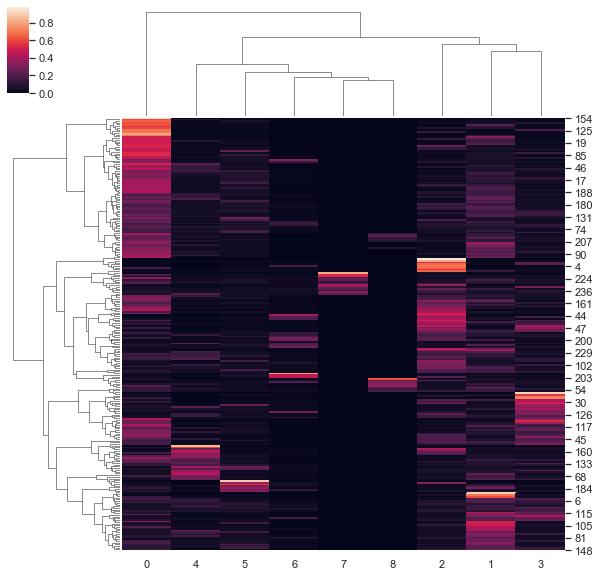

In [60]:
# 250, 500
sns.clustermap(kmeans_250b.cluster_centers_, method='ward')


 Including Babies in Heatmap: 
 - Group1: produce
 - Group2: 'dairy_eggs',  'beverages',  'snacks',
 - Group3: 'frozen',  'pantry',  'household',  'alcohol',  'babies'
 
 Parents are not an apparent cluster using this technique

In [75]:
# Cluster on produce vs other buying
sum_col_list = list(dept_percent_df)
sum_col_list.remove('produce')
produce_other_df=pd.DataFrame()
produce_other_df['other'] = dept_percent_df[sum_col_list].sum(axis=1)
produce_other_df['produce'] = dept_percent_df['produce']


,other,produce
user_id,,
1,0.928571,0.071429
2,0.809735,0.190265
3,0.568182,0.431818
4,0.888889,0.111111
5,0.500000,0.500000


In [76]:
kmeans_po =  MiniBatchKMeans(n_clusters=250, random_state=42,batch_size=500)
kmeans_po.fit(produce_other_df)

MiniBatchKMeans(batch_size=500, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=250, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

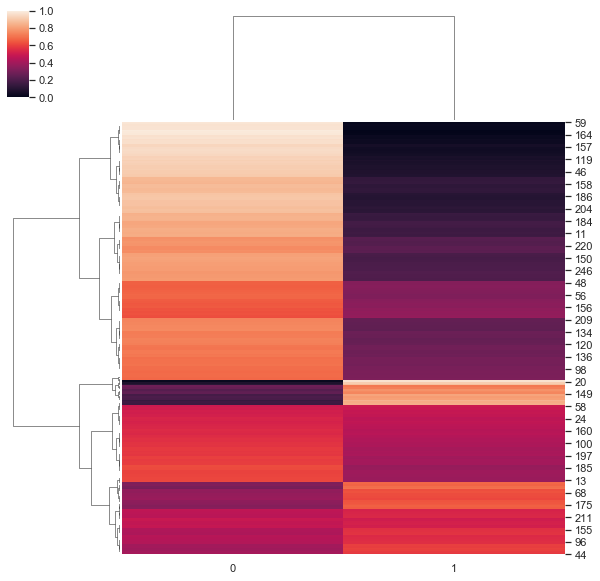

In [77]:
# 
sns.clustermap(kmeans_po.cluster_centers_, method='ward')

In [82]:
# Look at clustering on produce vs other frequent departments vs low freq departments
sum_col_list = list(dept_percent_df[sub_cols_babies])
sum_col_list.remove('produce')
produce_other_df=pd.DataFrame()
produce_other_df['other'] = dept_percent_df[sum_col_list].sum(axis=1)
produce_other_df['produce'] = dept_percent_df['produce']
produce_other_df['low_cols'] = 1-produce_other_df.other-produce_other_df.produce

In [84]:
produce_other_df.head()

,other,produce,low_cols
user_id,,,
1,0.871429,0.071429,0.057143
2,0.637168,0.190265,0.172566
3,0.500000,0.431818,0.068182
4,0.611111,0.111111,0.277778
5,0.347826,0.500000,0.152174


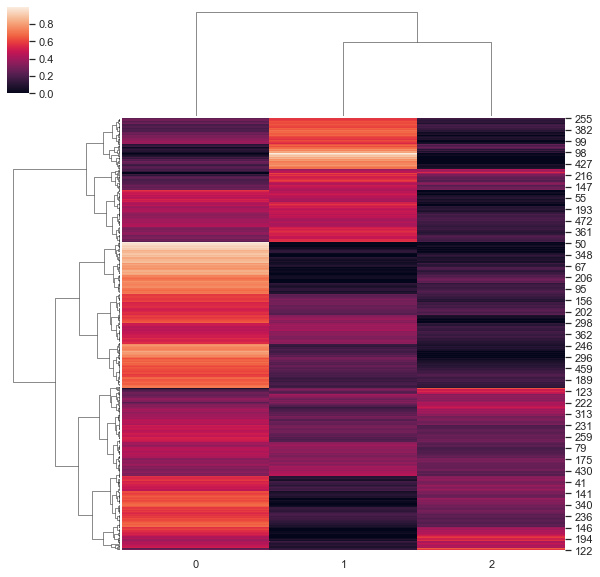

In [89]:
kmeans_pol =  MiniBatchKMeans(n_clusters=500, random_state=42,batch_size=1000)
kmeans_pol.fit(produce_other_df)

sns.clustermap(kmeans_pol.cluster_centers_, method='ward')